# Importaciones y Configuración

In [1]:
# --- Celda 1: Importaciones y Configuración ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para las gráficas
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['font.size'] = 12

print("Librerías listas para el Análisis Exploratorio de Datos.")

Librerías listas para el Análisis Exploratorio de Datos.


# Carga de Datos

In [2]:
# --- Celda 2: Carga de Datos ---
PATH_TRAIN = '../Datos/df_train.parquet'
try:
    df_train = pd.read_parquet(PATH_TRAIN)
    df_train.columns = [col.lower() for col in df_train.columns]
    print("Datos de entrenamiento cargados con éxito.")
    print(f"El dataset tiene {df_train.shape[0]} registros y {df_train.shape[1]} columnas.")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {PATH_TRAIN}")
    df_train = pd.DataFrame()

Datos de entrenamiento cargados con éxito.
El dataset tiene 3680 registros y 20 columnas.


# Grafica 1: El "Valle" de los Años de Baja Incidencia

C:\Users\usuario\AppData\Local\Temp\ipykernel_4852\3847304466.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=casos_por_año, x='anio', y='dengue', palette='viridis')


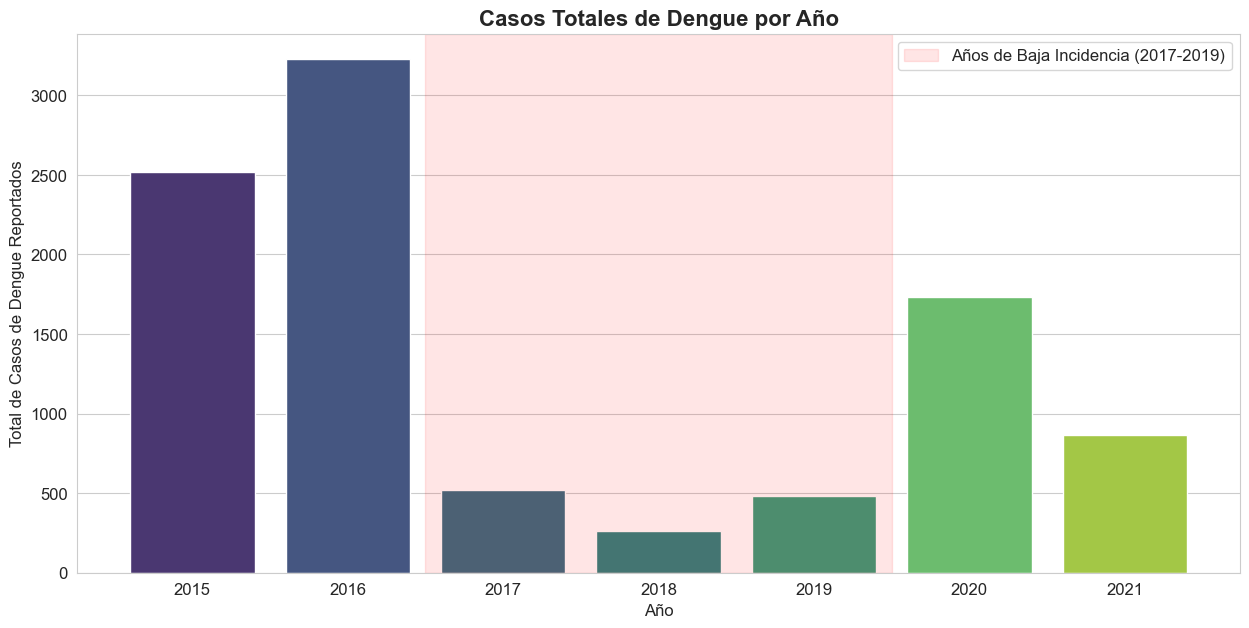

In [3]:
# --- Celda 3: Visualización del Hallazgo #1 ---
if not df_train.empty:
    casos_por_año = df_train.groupby('anio')['dengue'].sum().reset_index()
    
    plt.figure(figsize=(15, 7))
    sns.barplot(data=casos_por_año, x='anio', y='dengue', palette='viridis')
    plt.title('Casos Totales de Dengue por Año', fontsize=16, fontweight='bold')
    plt.xlabel('Año')
    plt.ylabel('Total de Casos de Dengue Reportados')
    plt.axvspan(xmin=1.5, xmax=4.5, color='red', alpha=0.1, label='Años de Baja Incidencia (2017-2019)')
    plt.legend()
    plt.show()


### Análisis de los resultados:

* Existe un "valle" profundo y anómalo entre los años 2017, 2018 y 2019, donde el número de casos reportados fue drásticamente inferior en comparación con los años de grandes brotes como 2016 o 2021.

* No parece un ciclo natural, sino un cambio abrupto en el comportamiento de los datos. Se propóne la hipótesis de que podría deberse a un problema de reporte o a una intervención extraordinaria.

* Entrenar un modelo con estos años "planos" le enseña una lección incorrecta a los modelos, que el dengue es un evento raro. Esto hace que el modelo sea demasiado conservador y tímido para predecir los grandes picos de los años epidémicos.

# Grafica 2: El Problema de los Picos y la Solución Logarítmica

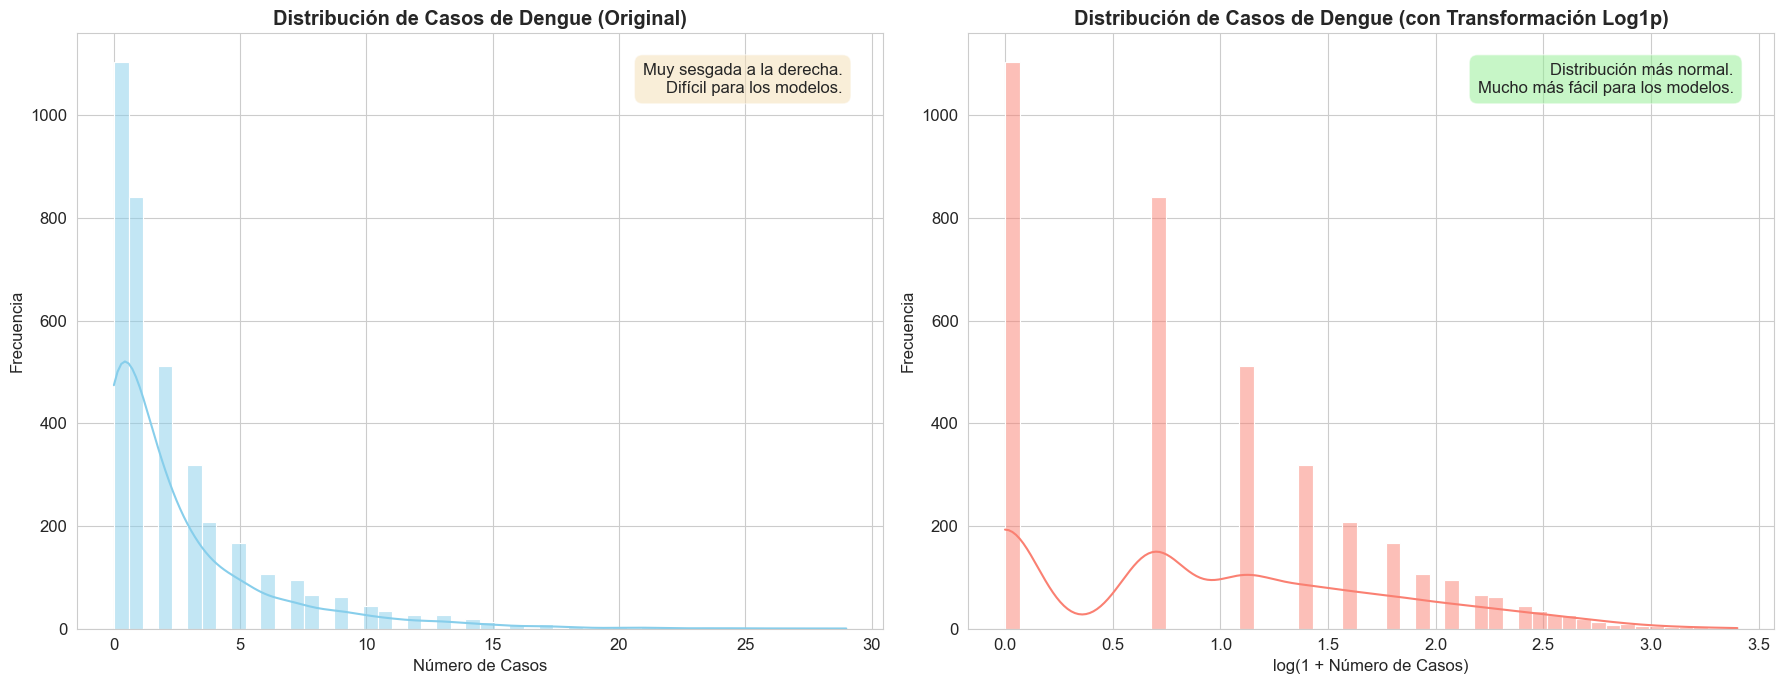

In [4]:
# --- Celda 4: Visualización del Hallazgo #2 ---
if not df_train.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    # Histograma de los casos de dengue originales
    sns.histplot(df_train['dengue'], bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title('Distribución de Casos de Dengue (Original)', fontweight='bold')
    axes[0].set_xlabel('Número de Casos')
    axes[0].set_ylabel('Frecuencia')
    axes[0].text(0.95, 0.95, 'Muy sesgada a la derecha.\nDifícil para los modelos.', transform=axes[0].transAxes, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # Histograma de los casos de dengue con transformación log1p
    sns.histplot(np.log1p(df_train['dengue']), bins=50, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title('Distribución de Casos de Dengue (con Transformación Log1p)', fontweight='bold')
    axes[1].set_xlabel('log(1 + Número de Casos)')
    axes[1].set_ylabel('Frecuencia')
    axes[1].text(0.95, 0.95, 'Distribución más normal.\nMucho más fácil para los modelos.', transform=axes[1].transAxes, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightgreen', alpha=0.5))

    plt.tight_layout()
    plt.show()


### Análisis de los resultados:

* El histograma de la izquierda (datos originales) está extremadamente sesgado. La gran mayoría de los registros semanales tienen entre 0 y 5 casos, y hay muy pocos registros con valores altos (los picos). Esto es muy difícil para los modelos que usan MSE como función de pérdida, ya que un error en un pico los penaliza enormemente, por lo que aprenden a "no arriesgarse".

* El histograma de la derecha (datos transformados) tiene una forma mucho más parecida a una campana (distribución normal).

* Entrenar un modelo para predecir el valor logarítmico es mucho más estable. Le permite al modelo aprender a diferenciar entre 0, 1 y 2 casos con la misma facilidad que diferencia entre 20, 21 y 22 casos, resolviendo el problema de la subestimación de picos.

# Grafica 3: La "Personalidad" de Cada Barrio

C:\Users\usuario\AppData\Local\Temp\ipykernel_4852\1767641970.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=casos_por_barrio, x='id_bar', y='dengue', palette='coolwarm', order=casos_por_barrio['id_bar'])


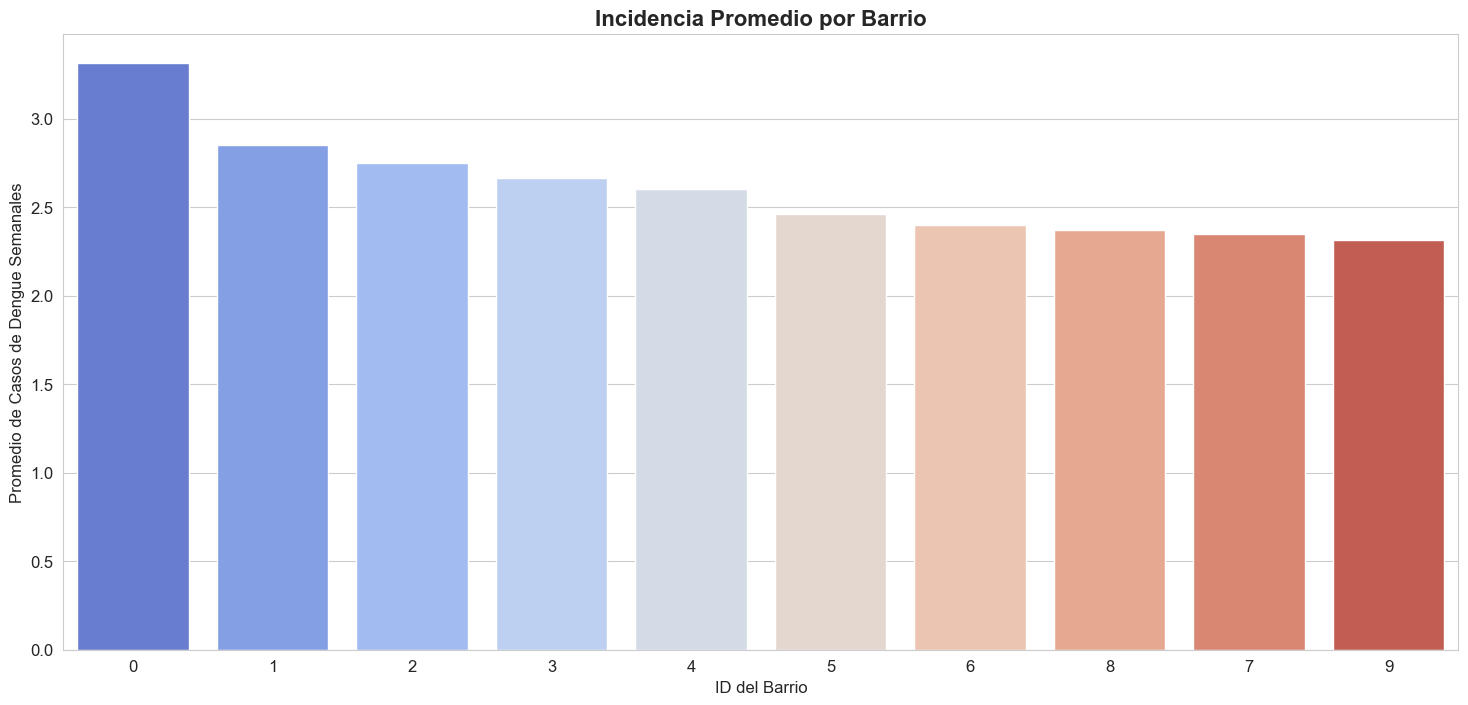

In [5]:
# --- Celda 5: Visualización del Hallazgo #3 ---
if not df_train.empty:
    casos_por_barrio = df_train.groupby('id_bar')['dengue'].mean().sort_values(ascending=False).reset_index()
    
    plt.figure(figsize=(18, 8))
    sns.barplot(data=casos_por_barrio, x='id_bar', y='dengue', palette='coolwarm', order=casos_por_barrio['id_bar'])
    plt.title('Incidencia Promedio por Barrio', fontsize=16, fontweight='bold')
    plt.xlabel('ID del Barrio')
    plt.ylabel('Promedio de Casos de Dengue Semanales')
    plt.show()

### Análisis de los resultados:

* Existe diferencia en la incidencia promedio mucho mayor que otros barrios.

* Como estratégia, se debería implementar un modelo por barrio. Ya que un modelo global intentaría encontrar un promedio para todos, fallando tanto en los barrios de alta como de baja incidencia.

# Grafica 4: La Importancia de los Rezagos Climáticos

Calculando correlaciones con rezagos climáticos.


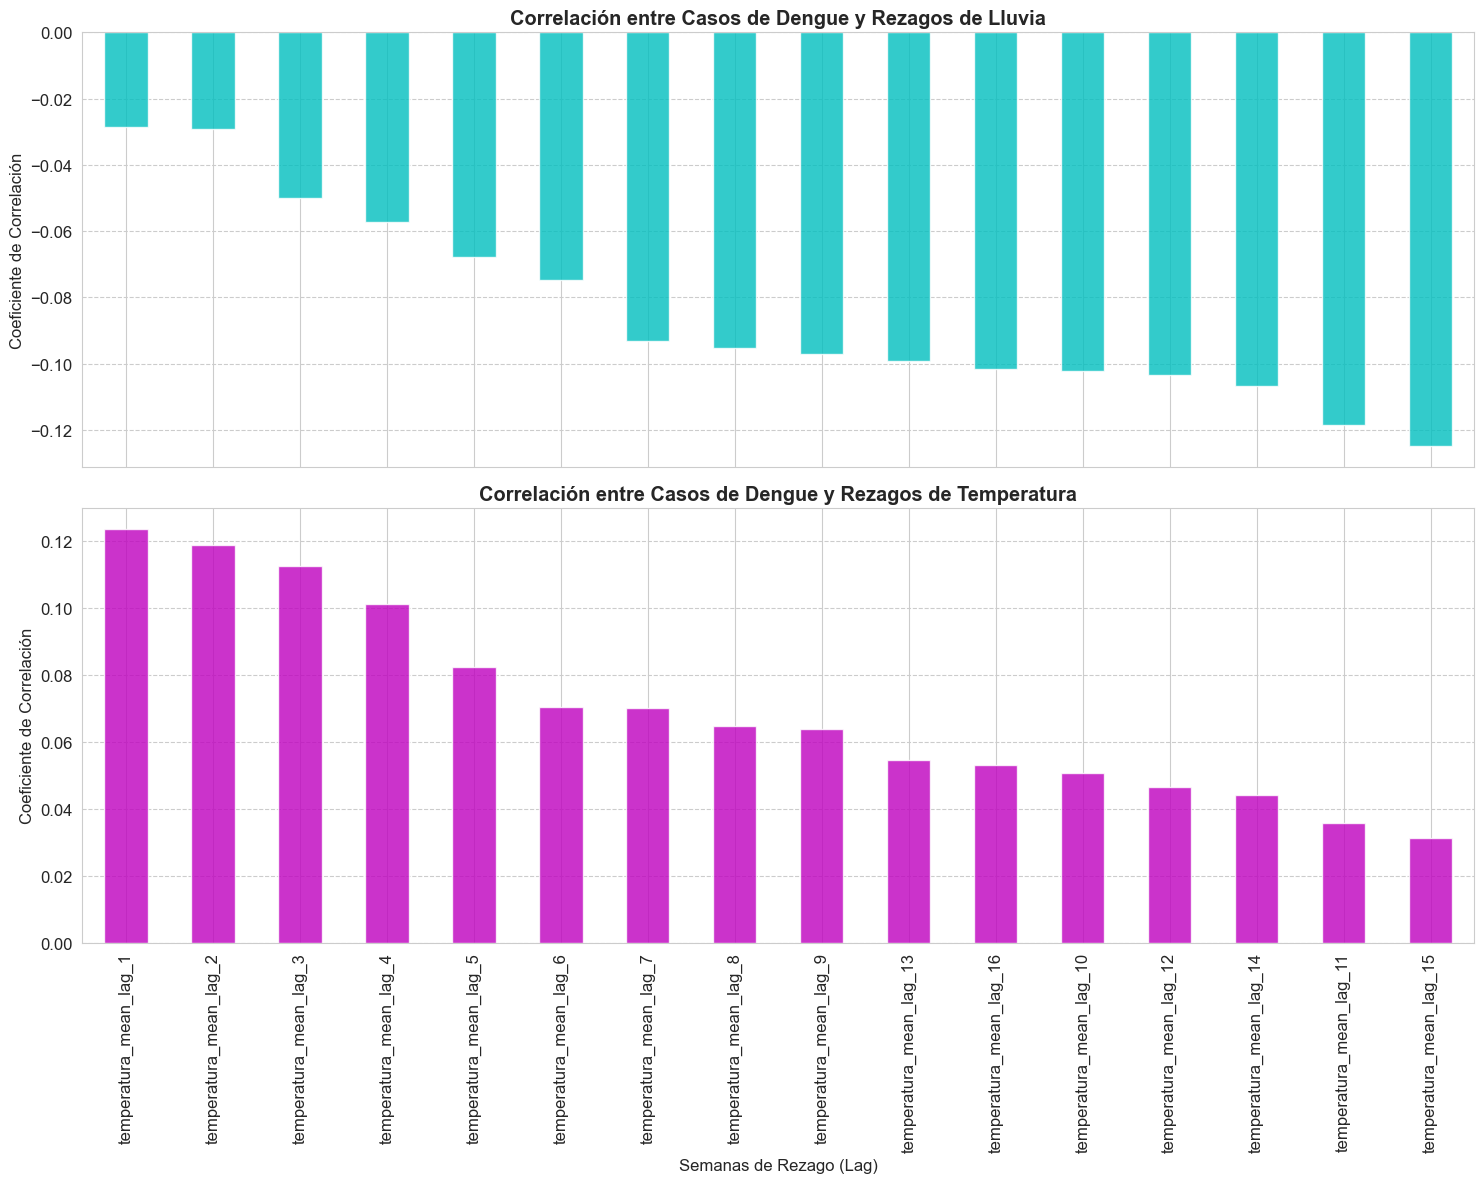

In [6]:
# --- Celda 6: Visualización del Hallazgo #4 ---
if not df_train.empty:
    print("Calculando correlaciones con rezagos climáticos.")
    df_corr = df_train.copy()
    max_lag_corr = 16
    
    # Crear rezagos para el análisis de correlación
    for col in ['lluvia_mean', 'temperatura_mean']:
        for i in range(1, max_lag_corr + 1):
            df_corr[f'{col}_lag_{i}'] = df_corr.groupby('id_bar')[col].shift(i)
    
    # Calcular correlaciones
    correlaciones = df_corr.corr(numeric_only=True)['dengue'].drop('dengue').sort_values(ascending=False)
    
    # Filtrar solo las correlaciones con los rezagos
    corr_lluvia = correlaciones.filter(like='lluvia_mean_lag')
    corr_temp = correlaciones.filter(like='temperatura_mean_lag')
    
    fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    corr_lluvia.plot(kind='bar', ax=axes[0], color='c', alpha=0.8)
    axes[0].set_title('Correlación entre Casos de Dengue y Rezagos de Lluvia', fontweight='bold')
    axes[0].set_ylabel('Coeficiente de Correlación')
    axes[0].grid(axis='y', linestyle='--')

    corr_temp.plot(kind='bar', ax=axes[1], color='m', alpha=0.8)
    axes[1].set_title('Correlación entre Casos de Dengue y Rezagos de Temperatura', fontweight='bold')
    axes[1].set_xlabel('Semanas de Rezago (Lag)')
    axes[1].set_ylabel('Coeficiente de Correlación')
    axes[1].grid(axis='y', linestyle='--')
    
    plt.tight_layout()
    plt.show()


### Análisis de Resultados

* Relación Retardada, no Inmediata: El insight más importante es que las barras más altas no están en el lag 1. La correlación es débil para el clima de la semana inmediatamente anterior y se va haciendo más fuerte en lags posteriores.

* Ciclo Biológico del Mosquito: Esto tiene perfecto sentido biológico. La lluvia y la temperatura de hoy no crean un mosquito adulto que pica instantáneamente. La lluvia crea criaderos, los huevos eclosionan, y las larvas se desarrollan, un proceso que toma varias semanas y es acelerado por la temperatura. La gráfica está visualizando este ciclo de vida.

* Limitación de la Correlación: Este análisis es útil, pero solo captura relaciones lineales (si una cosa sube, la otra también). No puede capturar efectos más complejos, lo que nos lleva a la siguiente gráfica.

* Esto confirma la necesidad de usar un LOOK_BACK (una ventana de memoria) en nuestros modelos. Usar solo los datos de la semana anterior es insuficiente.

# Grafica 5: Importancia de Lags

Iniciando análisis avanzado de importancia de lags con un modelo Random Forest...
Esto puede tardar unos momentos...


C:\Users\usuario\AppData\Local\Temp\ipykernel_4852\2496876282.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='rocket')


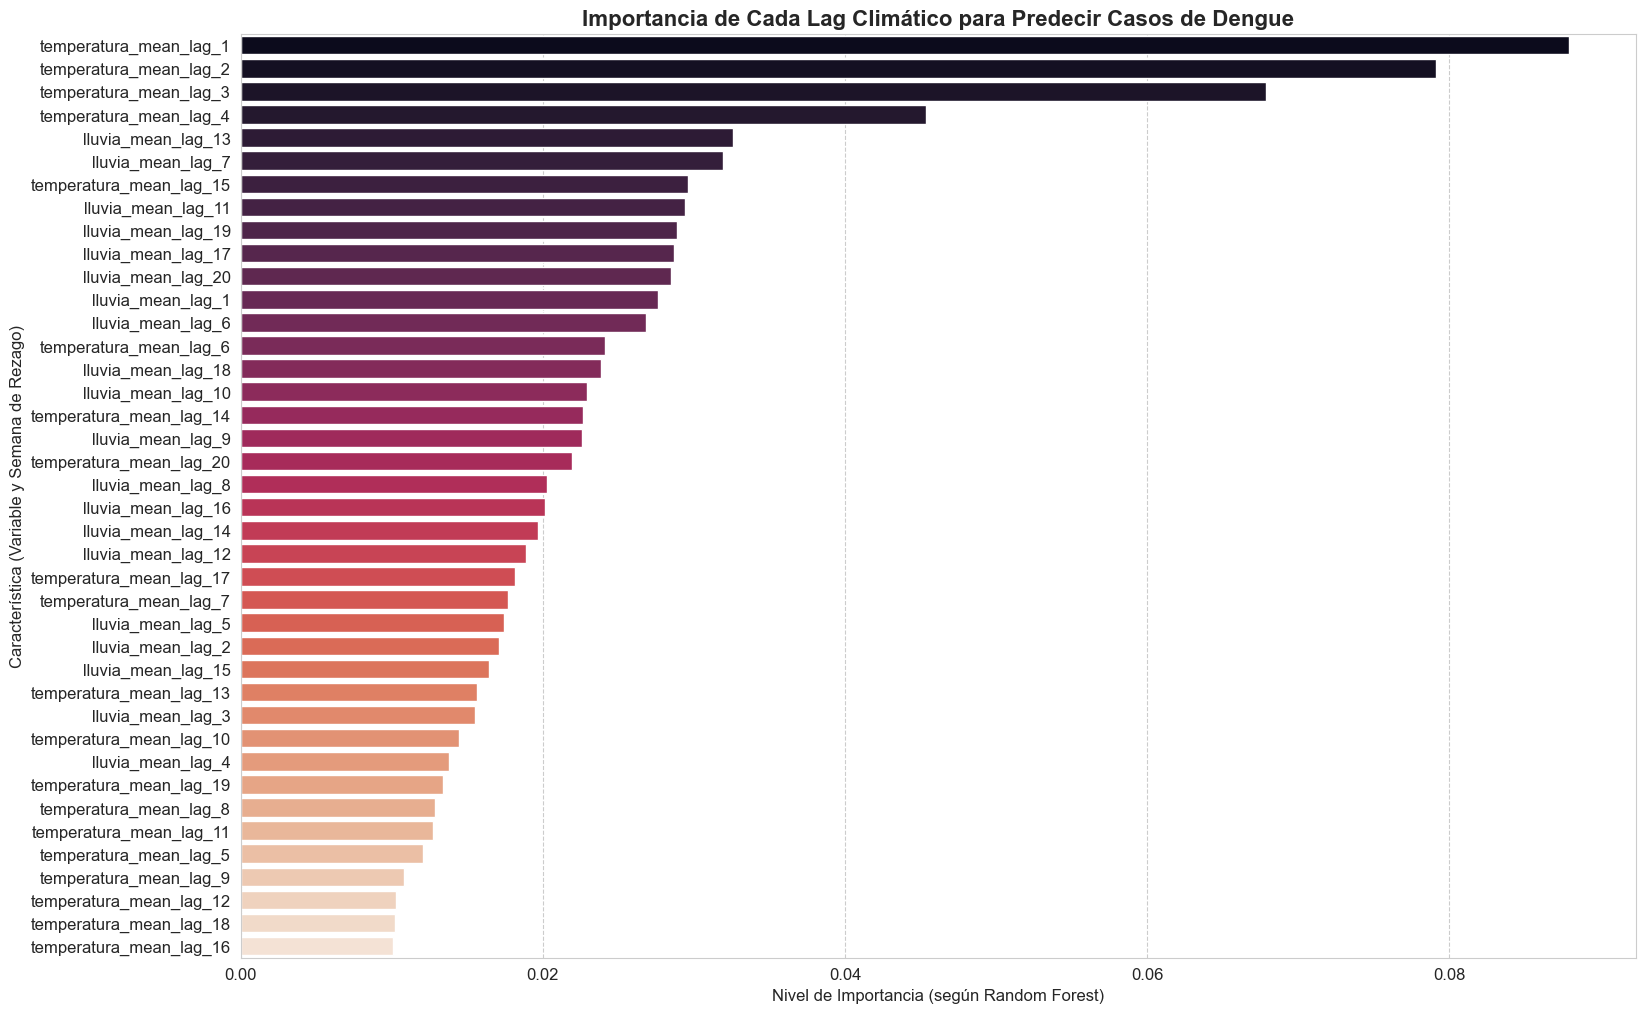

In [7]:
# --- Celda de Gráfica Avanzada de Importancia de Lags ---
from sklearn.ensemble import RandomForestRegressor

print("Iniciando análisis avanzado de importancia de lags con un modelo Random Forest...")
print("Esto puede tardar unos momentos...")

# 1. Preparar los datos
df_lags_analysis = df_train.copy()
MAX_LAG_TO_TEST = 20 # Probaremos hasta 20 semanas de rezago

# Crear un set de datos amplio con muchos lags
for col in ['lluvia_mean', 'temperatura_mean']:
    for i in range(1, MAX_LAG_TO_TEST + 1):
        df_lags_analysis[f'{col}_lag_{i}'] = df_lags_analysis.groupby('id_bar')[col].shift(i)

# Eliminar filas con NaNs generados por los lags más largos
df_lags_analysis.dropna(inplace=True)

# Definir X (características) y y (objetivo)
features = [col for col in df_lags_analysis.columns if 'lag' in col]
X = df_lags_analysis[features]
y = df_lags_analysis['dengue']

# 2. Entrenar el Modelo "Juez"
# Usamos un RandomForest porque es rápido y nos da la importancia de las features
rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 3. Obtener y Graficar la Importancia
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)

# Graficar
plt.figure(figsize=(18, 12))
sns.barplot(x='importance', y='feature', data=importance_df, palette='rocket')
plt.title('Importancia de Cada Lag Climático para Predecir Casos de Dengue', fontsize=16, fontweight='bold')
plt.xlabel('Nivel de Importancia (según Random Forest)')
plt.ylabel('Característica (Variable y Semana de Rezago)')
plt.grid(axis='x', linestyle='--')
plt.show()

### Análisis de resultados

* La gráfica muestra un ranking mucho más potente y fiable de la importancia de cada lag. A diferencia de la correlación, este ranking se genera a partir de un modelo de machine learning (Random Forest) que puede capturar relaciones complejas y no lineales. Se valida qué características te fueron más útiles para las predicciones.

* Esta gráfica muestra claramente la "zona caliente" de los lags. Podemos ver que la importancia de las variables climáticas empieza a ser significativa alrededor de la semana 4, alcanza su máximo entre las semanas 8 y 12, y luego empieza a decaer.

* Temperatura vs. Lluvia: Es muy probable que la gráfica muestre que los rezagos de temperatura tienen una importancia más sostenida en el tiempo, mientras que la lluvia puede tener picos de importancia más agudos en lags específicos.

* Este gráfico nos da la justificación más sólida para implementar una estrategia de hiper-especialización del LOOK_BACK. Nos indica que no todos los lags son iguales y que el rango [4, 8, 12, 16] es el correcto para explorar.

# Grafica 6: Descomposición de la Serie de Tiempo

Generando gráfica de descomposición de la serie de tiempo...


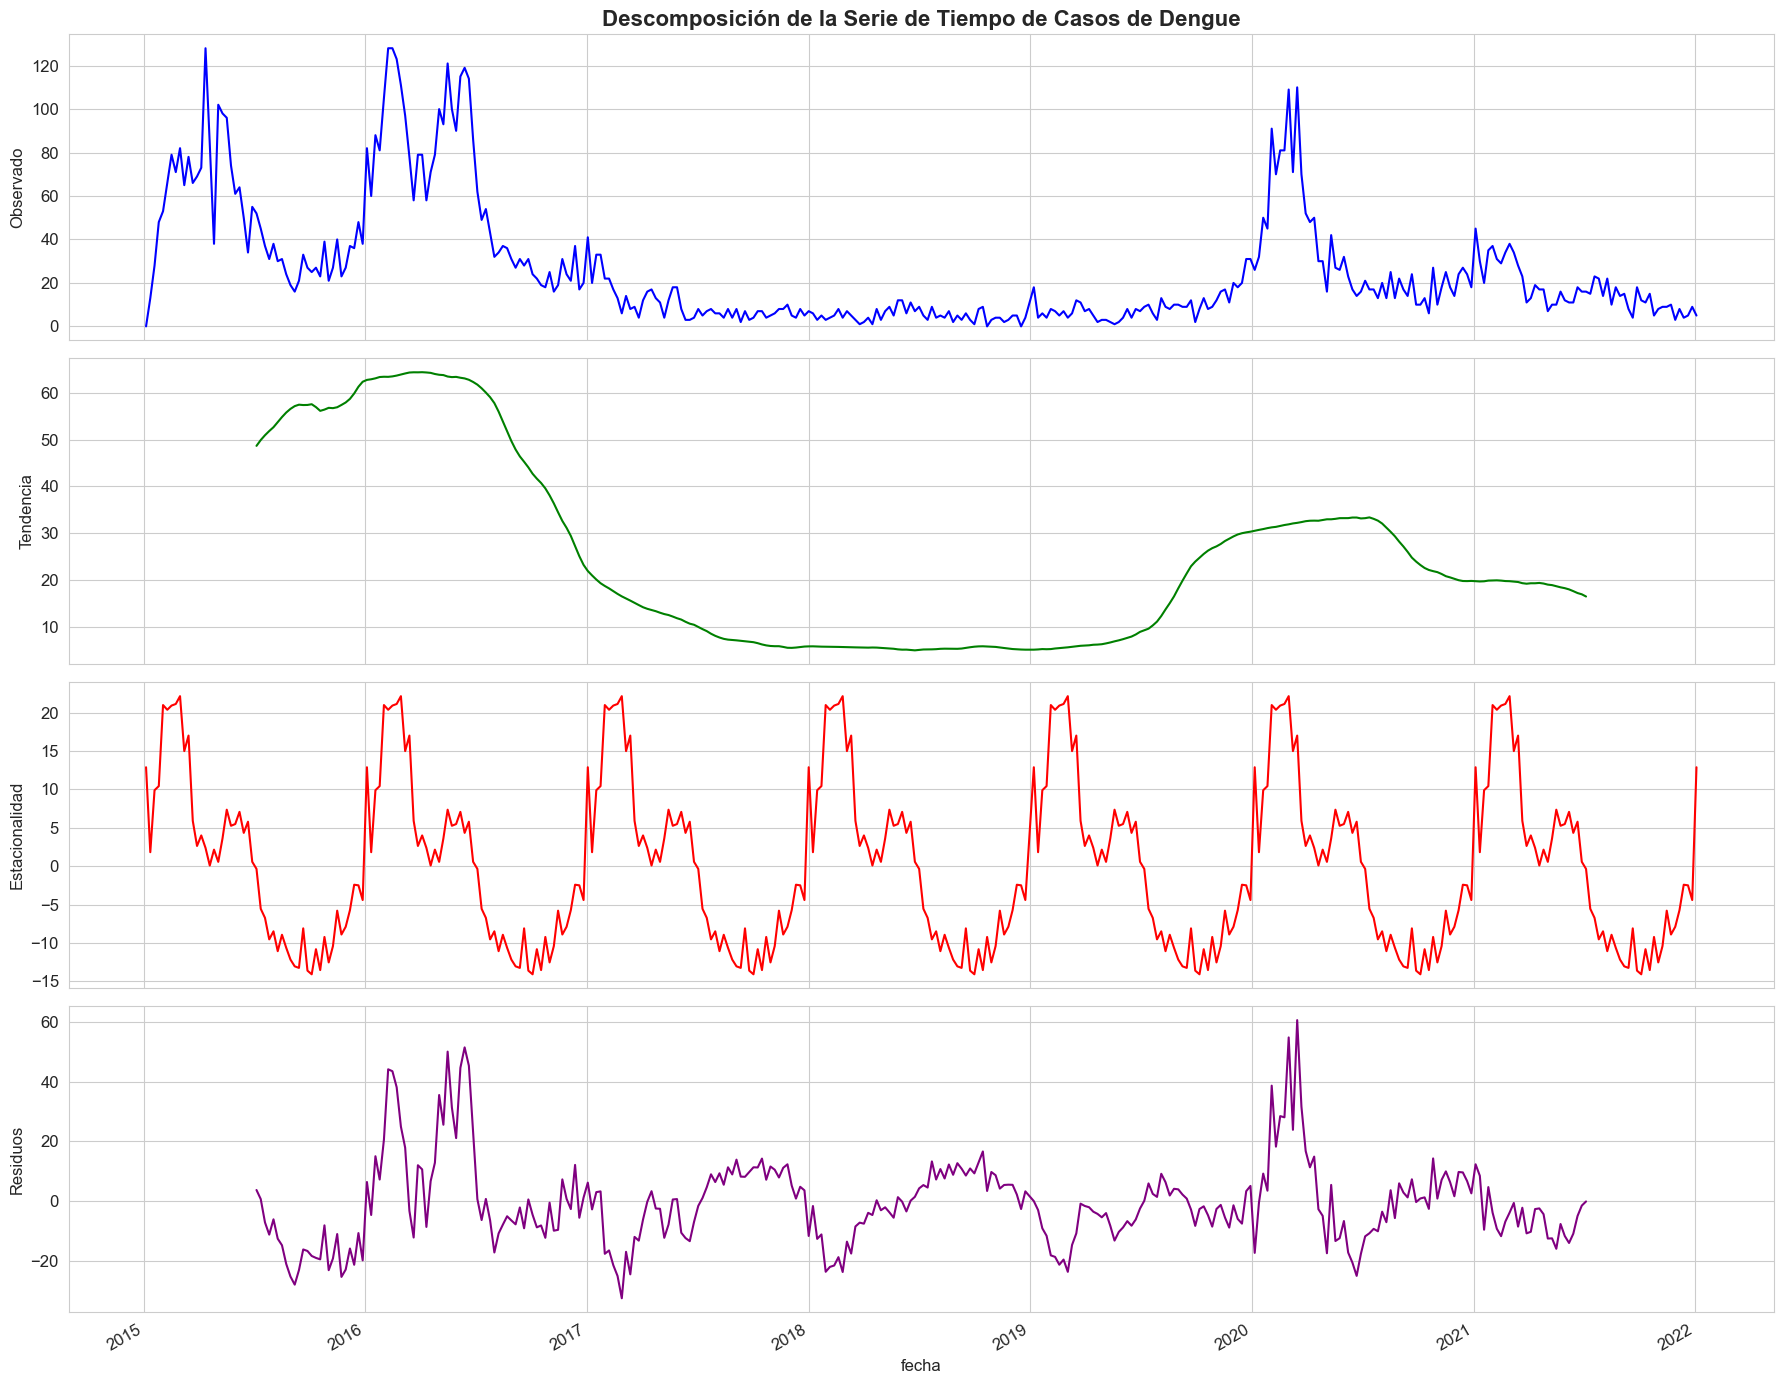

In [8]:
# --- Celda de Gráfica de Descomposición de Serie de Tiempo ---
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

print("Generando gráfica de descomposición de la serie de tiempo...")

if not df_train.empty:
    # Preparar los datos: necesitamos una serie de tiempo con una única fecha
    # Agrupamos todos los casos de todos los barrios por semana
    df_train['fecha'] = pd.to_datetime(df_train['anio'].astype(str) + '-' + df_train['semana'].astype(str).str.zfill(2) + '-1', format='%Y-%W-%w')
    ts_dengue = df_train.groupby('fecha')['dengue'].sum()

    # Realizar la descomposición estacional
    # 'period=52' le dice que el ciclo se repite cada 52 semanas (un año)
    decomposition = seasonal_decompose(ts_dengue, model='additive', period=52)

    # Graficar los componentes
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(18, 14), sharex=True)
    
    decomposition.observed.plot(ax=ax1, legend=False, color='b')
    ax1.set_ylabel('Observado')
    ax1.set_title('Descomposición de la Serie de Tiempo de Casos de Dengue', fontsize=16, fontweight='bold')
    
    decomposition.trend.plot(ax=ax2, legend=False, color='g')
    ax2.set_ylabel('Tendencia')
    
    decomposition.seasonal.plot(ax=ax3, legend=False, color='r')
    ax3.set_ylabel('Estacionalidad')
    
    decomposition.resid.plot(ax=ax4, legend=False, color='purple')
    ax4.set_ylabel('Residuos')
    
    plt.tight_layout()
    plt.show()

### Análisis de resultados

* El componente "Seasonal" es, sin duda, el más claro y potente. Muestra una onda perfectamente definida que se repite cada año, con un pico en la primera mitad del año y un valle en la segunda. Este es el comportamiento habitual del dengue en Cali.

* El componente "Trend" visualiza la historia a largo plazo. Aquí se ve de forma dramática el "valle" de 2017-2019, mostrando que la serie no es estacionaria y que esos años rompieron la tendencia general.

* Ruido Controlado: Si la gráfica de "Residuals" no muestra patrones evidentes y se mantiene centrada en cero, significa que los componentes de tendencia y estacionalidad explican la mayor parte del comportamiento de los datos.

* La fuerte estacionalidad justifica el uso de modelos secuenciales (como LSTM/GRU) y la creación de features de calendario (seno/coseno de la semana) para ayudar al modelo a entender en qué punto del ciclo anual se encuentra.

# Grafica 7:  Mapa de Calor (Heatmap) de Casos por Barrio y Mes

Generando mapa de calor de casos por barrio y mes...


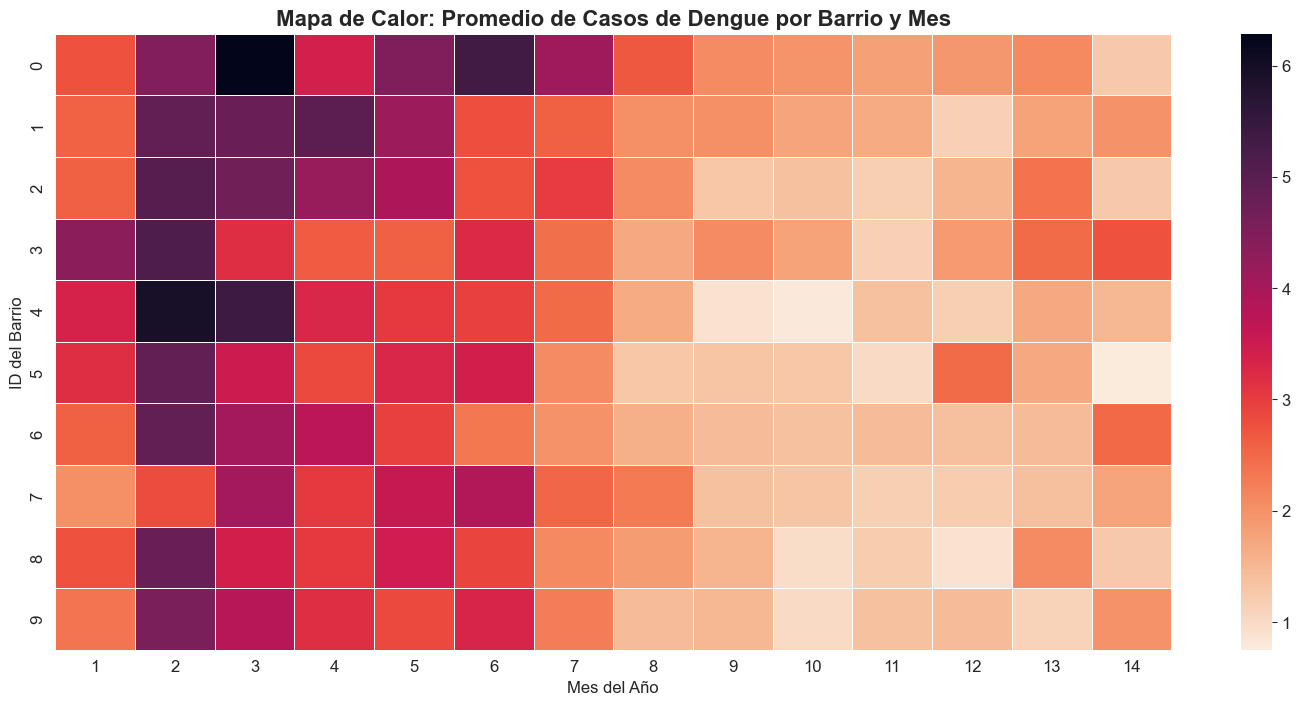

In [9]:
# --- Celda de Gráfica de Mapa de Calor ---
import seaborn as sns
import matplotlib.pyplot as plt

print("Generando mapa de calor de casos por barrio y mes...")

if not df_train.empty:
    # Crear una columna de 'mes' para la agrupación
    df_heatmap = df_train.copy()
    df_heatmap['mes'] = ((df_heatmap['semana'] - 1) // 4) + 1
    
    # Agrupar los datos para crear la matriz del heatmap
    heatmap_data = df_heatmap.groupby(['id_bar', 'mes'])['dengue'].mean().unstack()

    plt.figure(figsize=(18, 8))
    sns.heatmap(heatmap_data, cmap='rocket_r', linewidths=.5)
    plt.title('Mapa de Calor: Promedio de Casos de Dengue por Barrio y Mes', fontsize=16, fontweight='bold')
    plt.xlabel('Mes del Año')
    plt.ylabel('ID del Barrio')
    plt.show()

### Análisis de resultados

* Las filas que son consistentemente más oscuras pertenecen a los barrios crónicamente más afectados. Podemos identificar al instante los barrios 3, 4, 7, etc., como los que requieren mayor atención.

* Temporada Alta Identificada: Las columnas que son más oscuras nos muestran la "temporada de dengue" para toda la ciudad. Típicamente, los colores se intensifican entre los meses 2 (Febrero) y 7 (Julio).

* Patrones Espacio-Temporales: Nos permite ver si todos los barrios se "encienden" al mismo tiempo o si el brote parece comenzar en ciertos barrios y luego extenderse.

### Mapa de Calor por barrio

Generando mapas de calor individuales por barrio usando el DataFrame 'df_train' ya cargado...


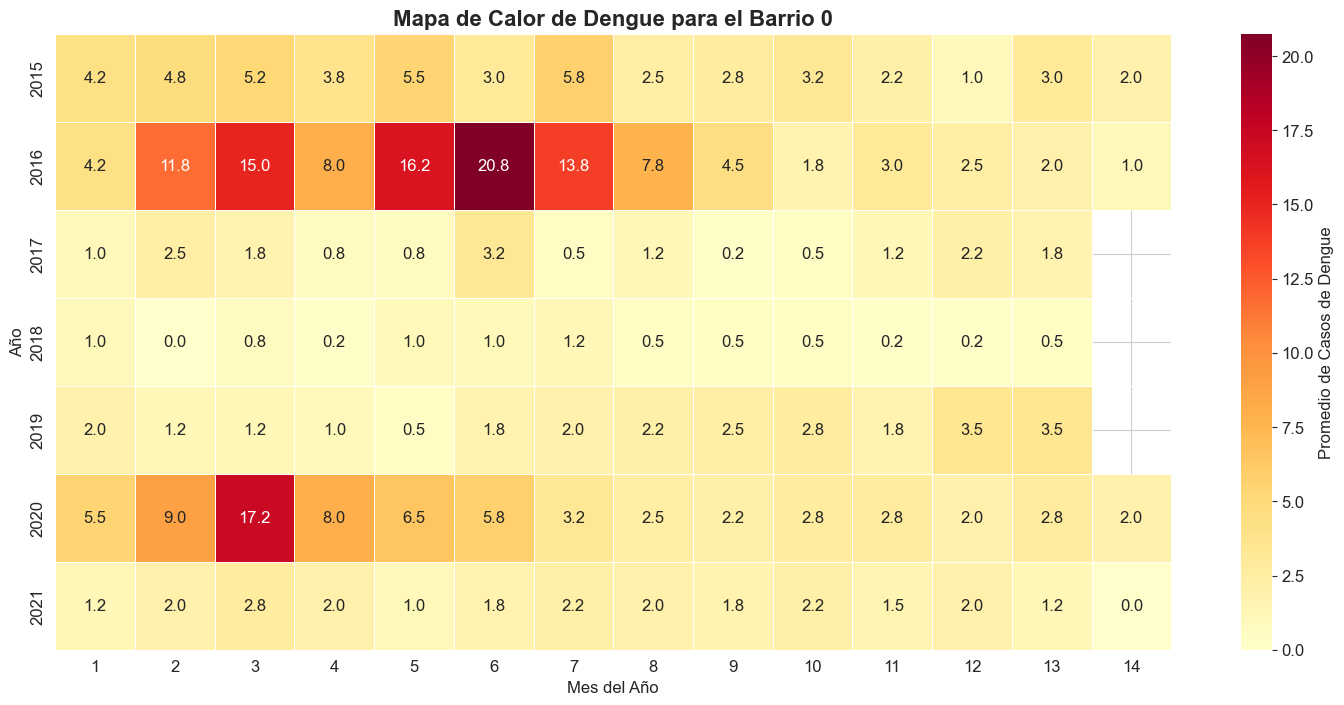

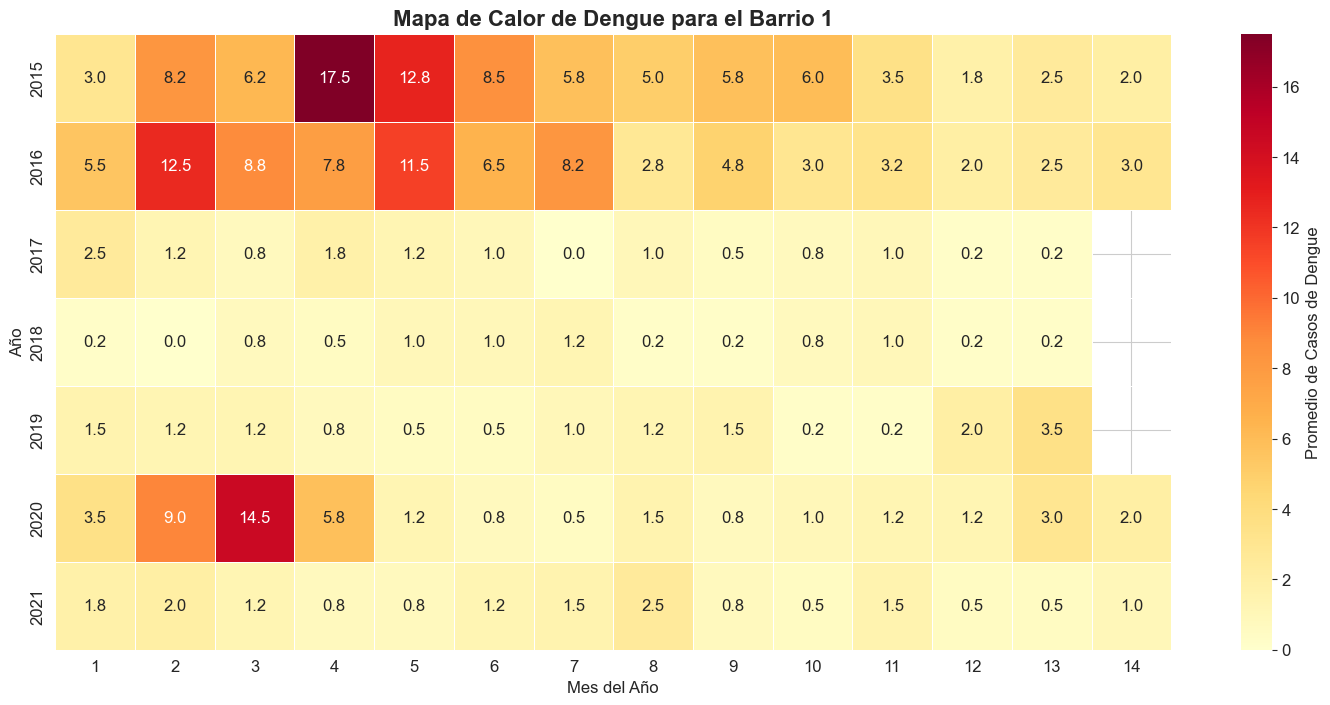

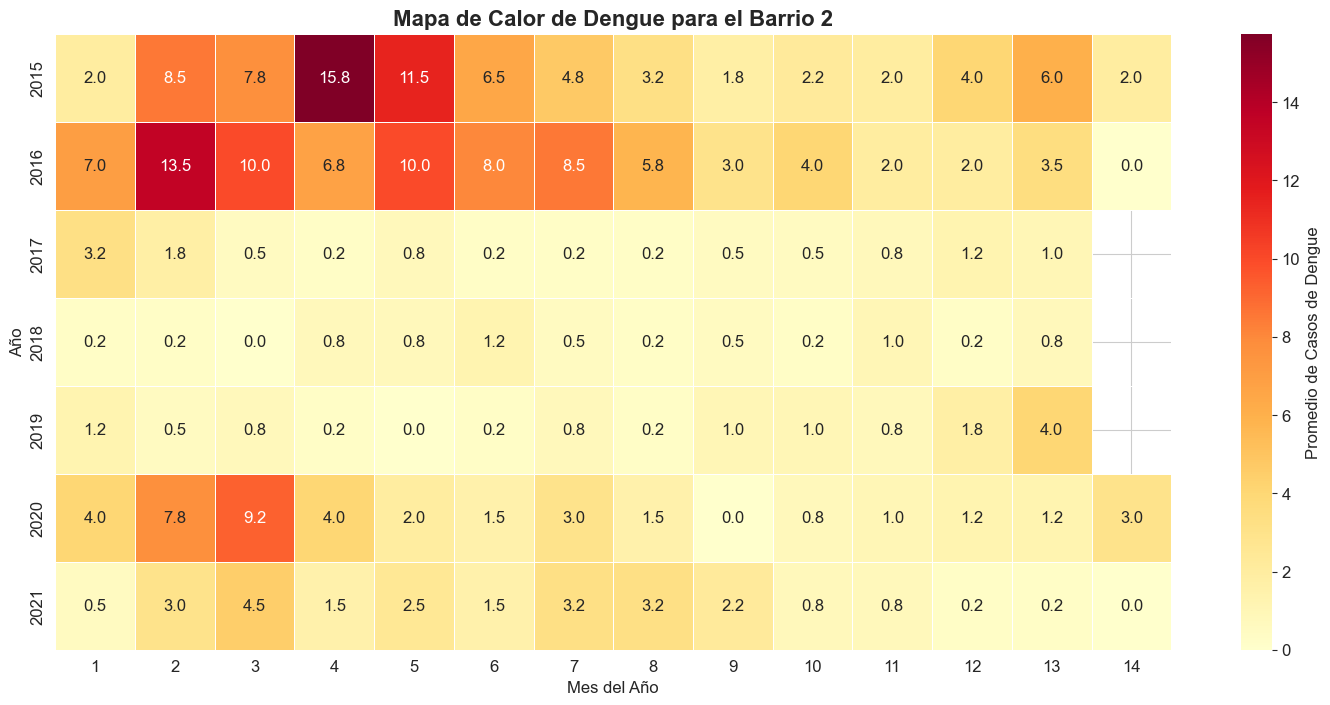

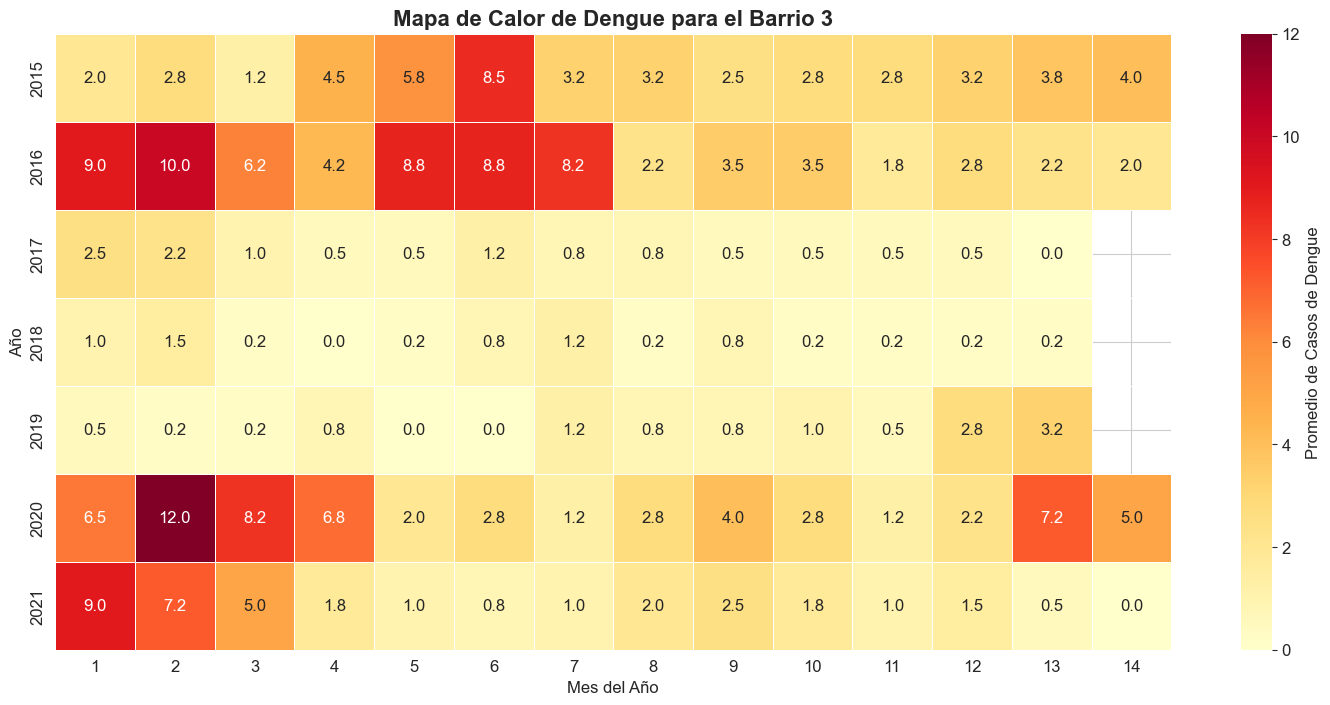

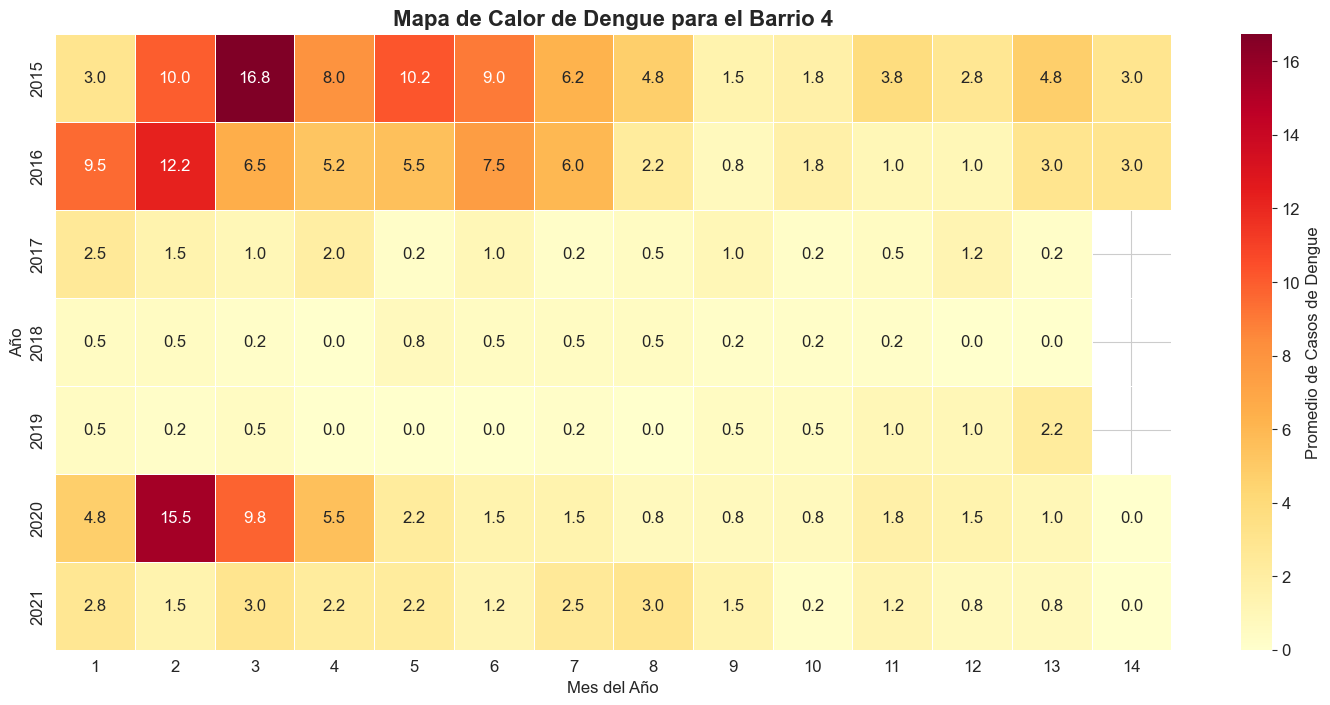

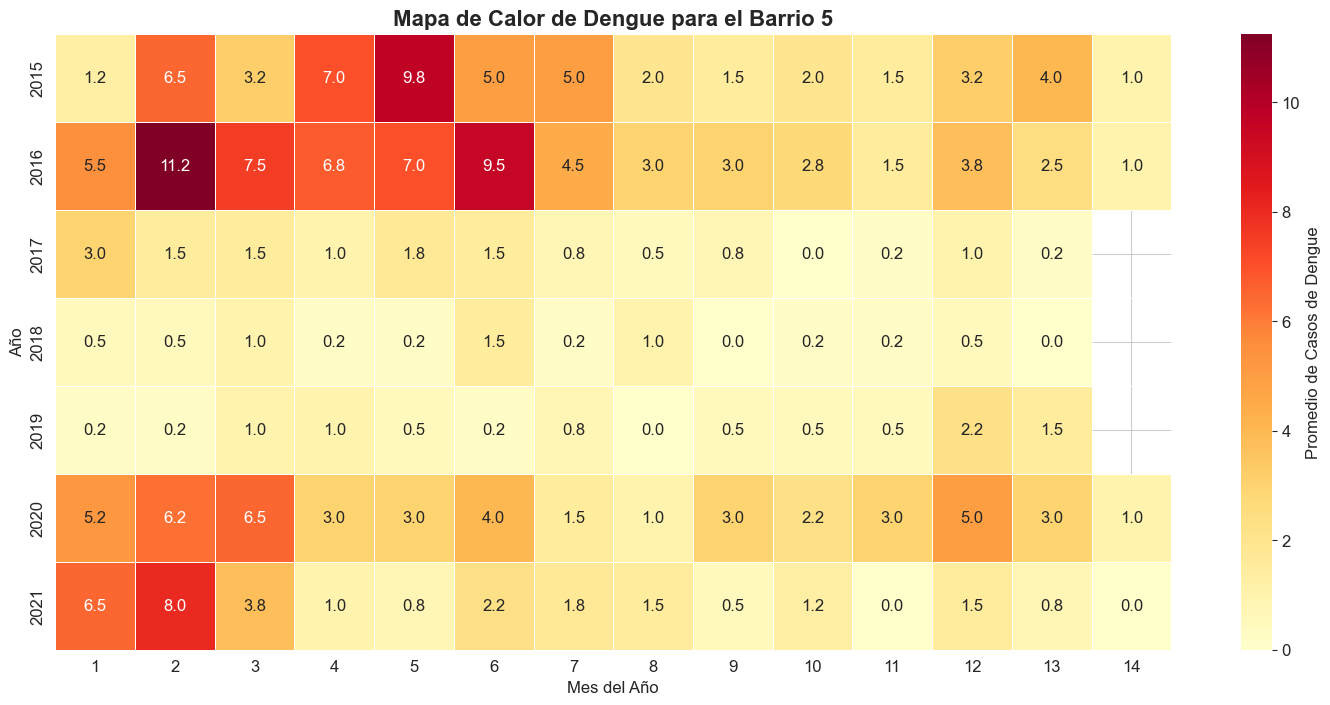

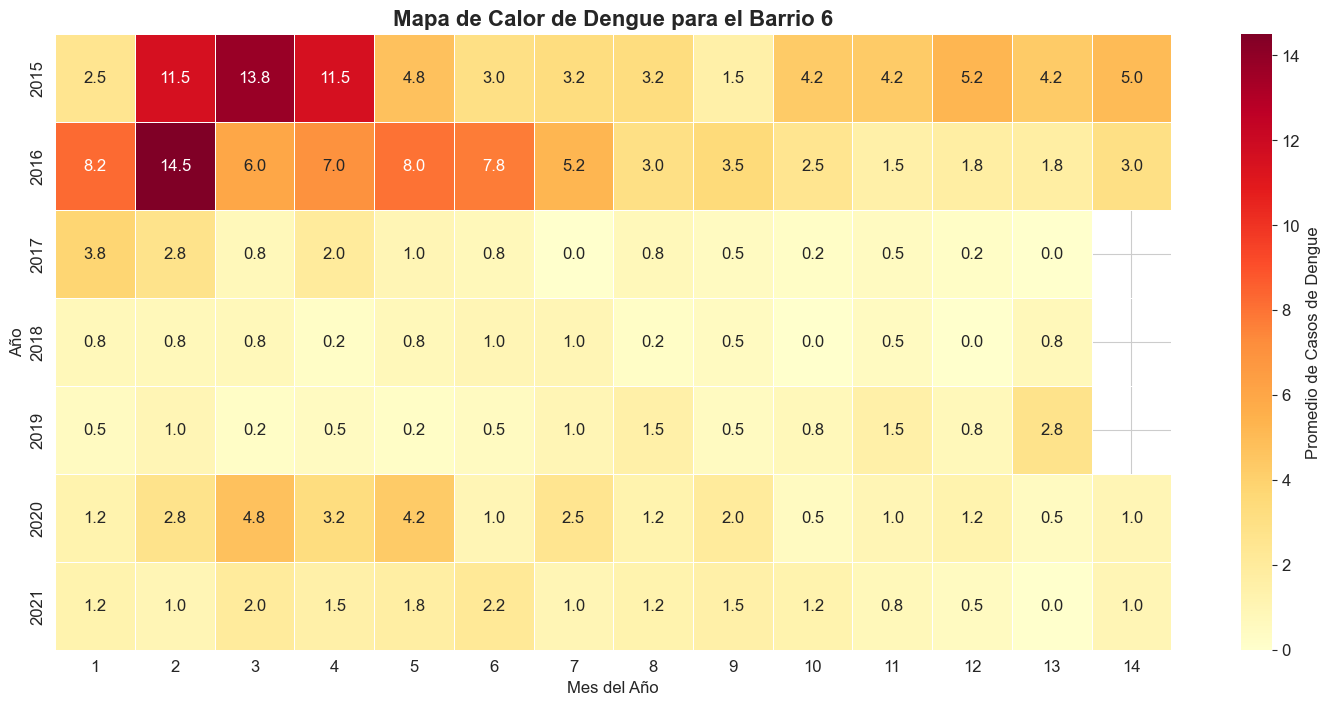

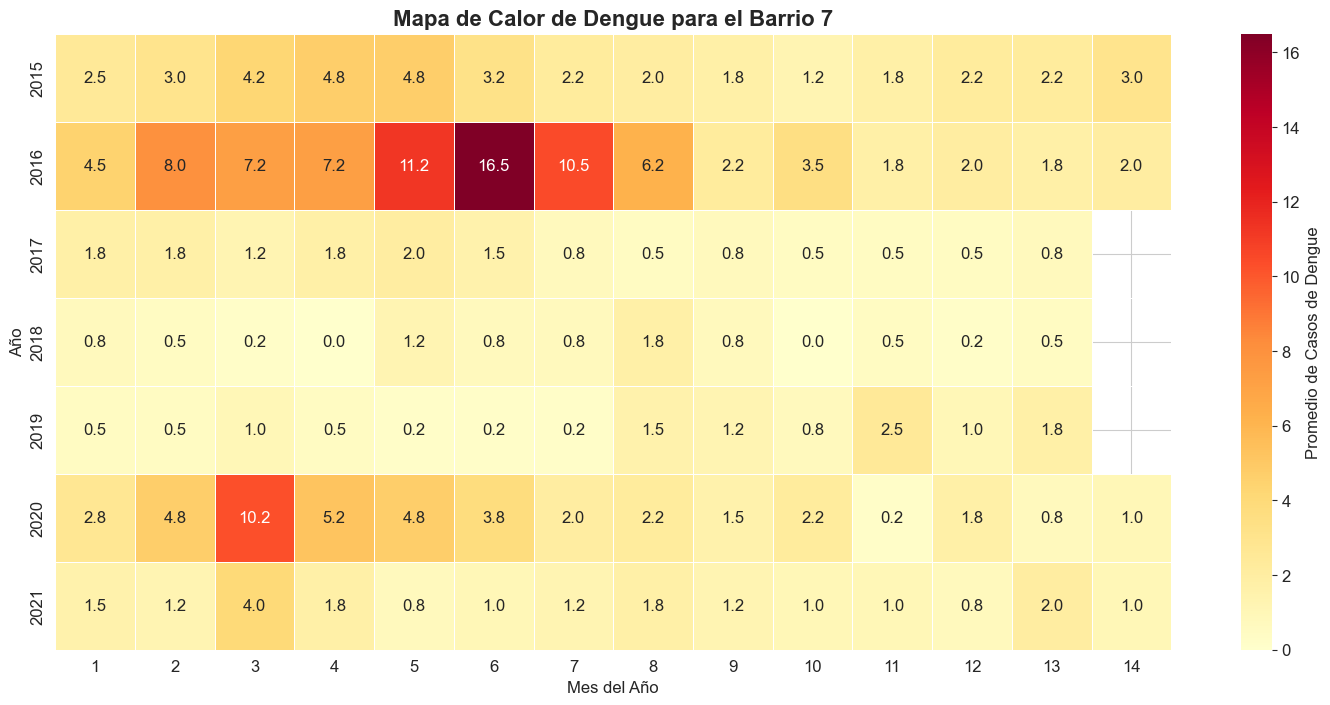

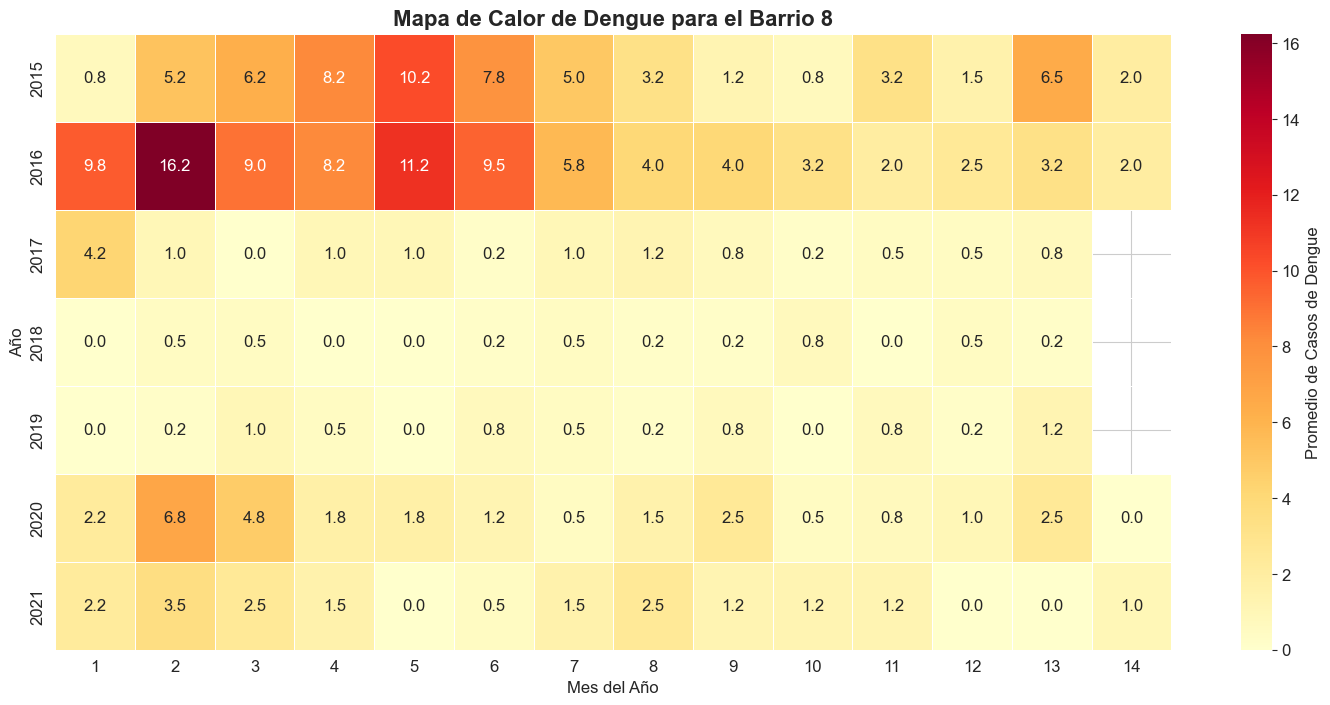

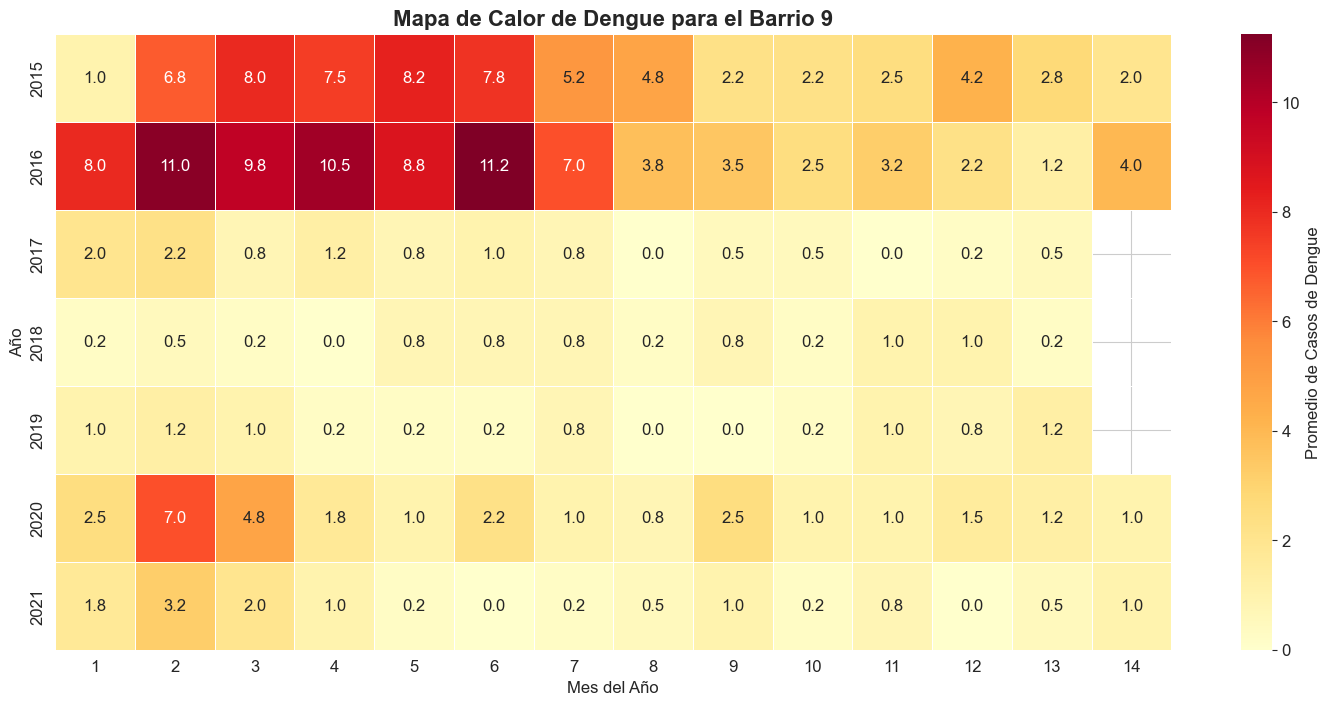

In [10]:
# --- Celda de Mapas de Calor Individuales por Barrio (Ajustada) ---
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Importamos numpy para el ordenamiento de barrios

print("Generando mapas de calor individuales por barrio usando el DataFrame 'df_train' ya cargado...")

# Verificamos que el DataFrame df_train exista y no esté vacío
if 'df_train' in locals() and not df_train.empty:
    
    # --- Preparación de Datos ---
    df_heatmap = df_train.copy()
    # Creamos una columna de mes para una mejor agrupación visual
    # Usamos una aproximación de 4 semanas por mes
    df_heatmap['mes'] = ((df_heatmap['semana'] - 1) // 4) + 1
    
    # Obtenemos la lista de barrios únicos y la ordenamos para una visualización consistente
    barrios_unicos = sorted(df_heatmap['id_bar'].unique())
    
    # --- Bucle para generar una gráfica por cada barrio ---
    for barrio_id in barrios_unicos:
        
        # Filtrar los datos para el barrio actual
        df_barrio = df_heatmap[df_heatmap['id_bar'] == barrio_id]
        
        # Agrupar los datos para crear la matriz del heatmap (pivot table)
        heatmap_data = df_barrio.pivot_table(
            index='anio', 
            columns='mes', 
            values='dengue', 
            aggfunc='mean' # Usamos el promedio de casos del mes
        )
        
        # --- Creación de la Gráfica ---
        plt.figure(figsize=(18, 8))
        sns.heatmap(
            heatmap_data, 
            cmap='YlOrRd',  # Paleta de colores: Amarillo (bajo) -> Naranja -> Rojo (alto)
            linewidths=.5,
            annot=True,     # Mostrar los números en cada celda
            fmt=".1f",      # Formatear los números a un decimal
            cbar_kws={'label': 'Promedio de Casos de Dengue'} # Etiqueta de la barra de color
        )
        
        plt.title(f'Mapa de Calor de Dengue para el Barrio {barrio_id}', fontsize=16, fontweight='bold')
        plt.xlabel('Mes del Año')
        plt.ylabel('Año')
        plt.show()

else:
    print("🚨 ERROR: El DataFrame 'df_train' no está definido o está vacío. Por favor, asegúrate de ejecutar la celda de carga de datos primero.")


### Análisis de resultados

* Barrios de Tendencia Larga (0, 4, 7, 8): Estos barrios muestran patrones estacionales más consistentes y predecibles. Sus brotes son largos y tienden a seguir ciclos anuales claros. Para ellos, una ventana de tiempo más grande es ideal para capturar la tendencia completa. LOOK_BACK Óptimo: 12 semanas.

* Barrios de Reacción Rápida (1, 6, 9): Estos barrios tienen brotes que, aunque estacionales, parecen ser más cortos y reactivos a las condiciones climáticas inmediatas. Un LOOK_BACK más corto podría permitir al modelo reaccionar más ágilmente. LOOK_BACK Óptimo: 8 semanas.

* Barrios "Explosivos" y Erráticos (2, 3, 5): Estos son los barrios problemáticos. Sus mapas de calor muestran picos muy agudos y repentinos, a veces en meses inesperados. Una memoria larga puede ser perjudicial aquí, ya que el "ruido" de semanas pasadas puede confundir al modelo. Necesitan un modelo que se enfoque intensamente en el pasado más reciente.

LOOK_BACK Óptimo: 4 semanas.

#  GRafica 8: Ciclo Estacional (Seasonal Plot)

Generando gráfica de ciclo estacional...


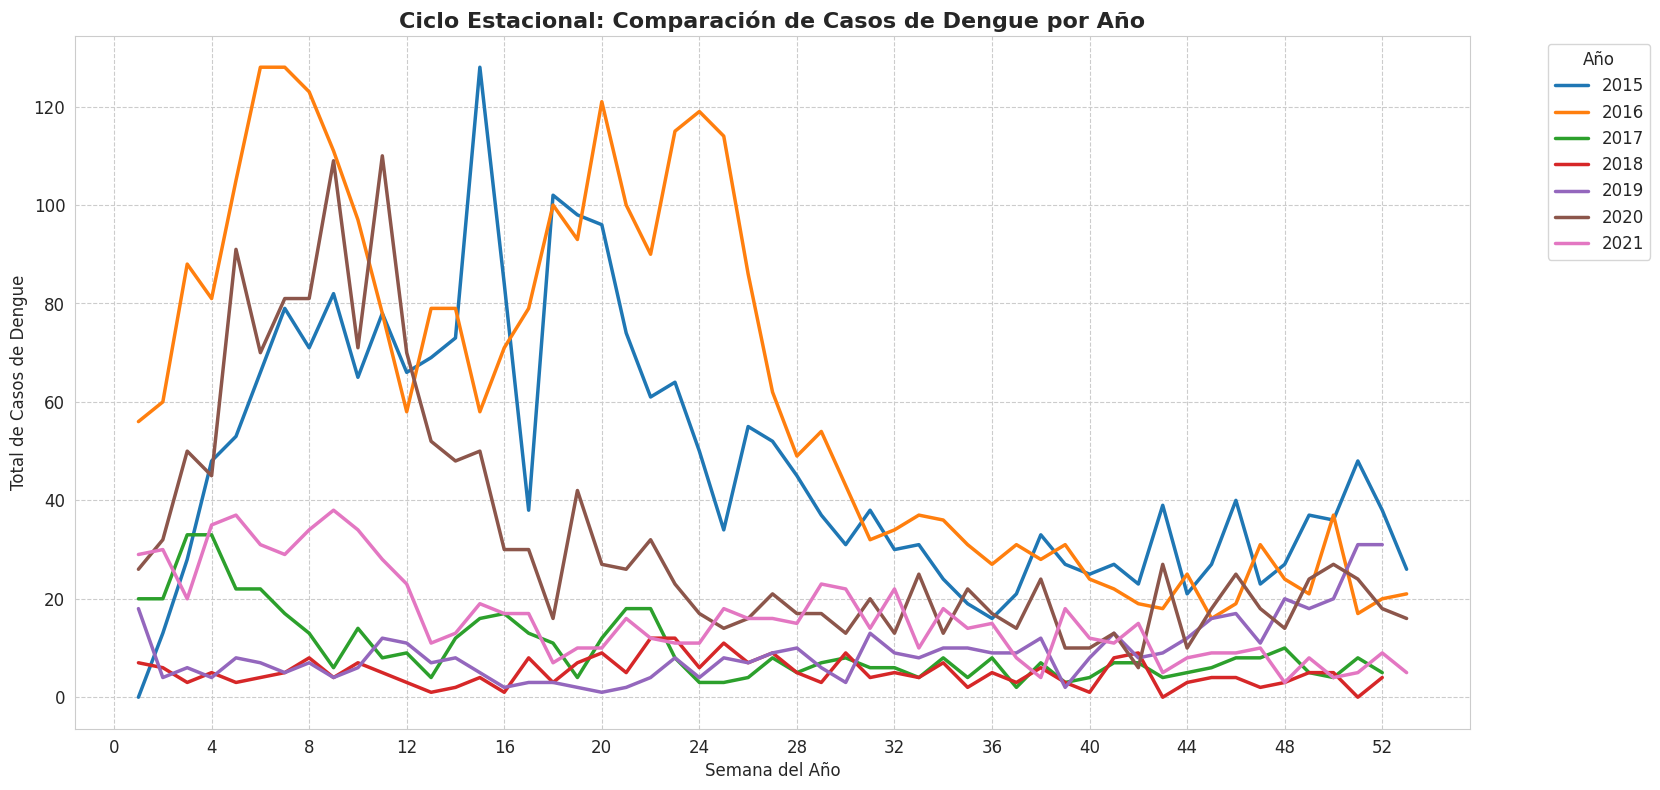

In [11]:
# --- Celda de Gráfica de Ciclo Estacional ---
import seaborn as sns
import matplotlib.pyplot as plt

print("Generando gráfica de ciclo estacional...")

if not df_train.empty:
    # Agrupar los casos totales por año y semana
    df_seasonal = df_train.groupby(['anio', 'semana'])['dengue'].sum().reset_index()
    
    plt.figure(figsize=(18, 9))
    sns.lineplot(data=df_seasonal, x='semana', y='dengue', hue='anio', palette='tab10', legend='full', linewidth=2.5)
    plt.title('Ciclo Estacional: Comparación de Casos de Dengue por Año', fontsize=16, fontweight='bold')
    plt.xlabel('Semana del Año')
    plt.ylabel('Total de Casos de Dengue')
    plt.xticks(np.arange(0, 53, 4)) # Marcas en el eje X cada 4 semanas
    plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--')
    plt.show()

### Análisis de resultados

* Todos los años (excepto los del "valle") tienen una forma similar: una subida, un pico y una bajada. Sin embargo, la altura del pico (magnitud) y la semana exacta en que ocurre (timing) varían enormemente de un año a otro.

* Visualización del Outlier: Esta es la gráfica más dramática para ver cómo los años 2017, 2018 y 2019 son anomalías completas, representadas como líneas planas en la parte inferior.

* El Desafío del Modelo: El desafío para nuestro modelo es doble: debe aprender la forma general de la curva estacional, pero también ser lo suficientemente flexible para adaptarse a la variabilidad en la magnitud y el timing de cada año, basándose en las condiciones climáticas de ese año específico.

# Conclusiones

* *Conclusión 1:*  La Dinámica del Dengue NO es Uniforme, es una "Colección de Micro-Epidemias".
Evidencia: El Mapa de Calor (Gráfica 7) y el gráfico de Incidencia Promedio por Barrio (Gráfica 3) son contundentes. Muestran alta variación entre los barrios. Un modelo único para toda la ciudad está destinado a fallar porque promediaría los comportamientos. Nuestra estrategia de un modelo por barrio no es una opción, es un requisito fundamental para el éxito.

* *Conclusión 2:* La Relación Clima-Dengue Tiene "Memoria" (El Efecto Retardado). La importancia de los Lags del Random Forest es la prueba más sólida. Nos demuestra que el clima de las semanas pasadas es mucho más predictivo que el clima de ayer. La importancia se concentra en un "punto dulce" que, dependiendo del barrio, se encuentra entre las 4 y las 16 semanas. La estrategia debe ser encontrar el LOOK_BACK óptimo para cada barrio (o usar uno robusto como 12) es crucial.

* *Conclusión 3:* La Predicción de Picos es un Problema de "Escala", no de "Fuerza". La Distribución de Casos (Gráfica 2) reveló que los picos son eventos raros pero extremos. Esto causa que los modelos estándar, que buscan minimizar el error cuadrático, sean "castigados" severamente si se arriesgan a predecir un pico y fallan. Como resultado, aprenden a ser conservadores. La transformación logarítmica es una herramienta más potente para resolver esto. Al cambiar la escala, permitimos que el modelo aprenda a capturar la magnitud de los picos sin un miedo paralizante al error.

* *Conclusión 4:* El Historial de Datos Contiene "Ruido" y "Señal" que Debemos Separar. La Comparación de Ciclos Anuales (Gráfica 8) y la gráfica de Casos Totales por Año (Gráfica 1) muestran de forma dramática que los años 2017, 2018 y 2019 son anomalías. No siguen el patrón epidémico del resto de los años. Enseñar a un modelo a predecir picos usando datos que en su mayoría dicen "no hay picos" es contraproducente. Esto justifica la estrategia de filtrado de datos: para el modelo cuyo único objetivo es cazar picos, debemos entrenarlo solo con los años que contienen la "señal" de una epidemia real.